In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# 加载
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.1

tf.set_random_seed(55)
np.random.seed(55)

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
#########################################################################################################

In [33]:
class FNN(object):
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate : float
    drop_out : float
    Layers : list
        The number of layers
    N_hidden : list
        The numbers of nodes in layers
    D_input : int
        Input dimension
    D_label : int
        Label dimension
    Task_type : string
        'regression' or 'classification'
    L2_lambda : float
        
    Returns
    -------

    """
    def __init__(self, learning_rate, drop_keep, Layers, N_hidden, D_input, D_label, Task_type='regression', L2_lambda=0.0):
        
        #var
        self.learning_rate = learning_rate
        self.drop_keep = np.array(drop_keep).astype(np.float32)
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        self.Task_type = Task_type
        self.L2_lambda = L2_lambda
        
        # Placeholders
        with tf.name_scope('Input'):
            self.inputs = tf.placeholder(tf.float32, [None, D_input], name="inputs")
        with tf.name_scope('Label'):
            self.labels = tf.placeholder(tf.float32, [None, D_label], name="labels")
        with tf.name_scope('keep_rate'):
            self.drop_keep_rate = tf.placeholder(tf.float32, name="dropout_keep")
        
        # accumulate l2 regularization

        self.l2_penalty = tf.constant(0.0)
        
        # build network
        self.build('F')
        
    def weight_init(self,shape):
        # shape : list [in_dim, out_dim]
        # can change initialization here
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_init(self,shape):
        # can change initialization here
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name+'_summaries'):
            mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        
        with tf.name_scope(name+'_stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('_stddev/' + name, stddev)
        
        tf.summary.scalar('_max/' + name, tf.reduce_max(var))
        tf.summary.scalar('_min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)

    def layer(self,in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name+'_weights'):
                weights = self.weight_init([in_dim, out_dim])
                
                self.W.append(weights)
                self.variable_summaries(weights, layer_name + '/weights')
            
            with tf.name_scope(layer_name+'_biases'):
                biases = self.bias_init([out_dim])
                self.variable_summaries(biases, layer_name + '/biases')
            
            with tf.name_scope(layer_name+'_Wx_plus_b'):
                pre_activate = tf.matmul(in_tensor, weights) + biases
                tf.summary.histogram(layer_name + '/pre_activations', pre_activate)
            
            activations = act(pre_activate, name='activation')
            tf.summary.histogram(layer_name + '/activations', activations)
        
        return activations, tf.nn.l2_loss(weights)

    def drop_layer(self,in_tensor):
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped

    def build(self, prefix):
        # build networks

        incoming = self.inputs
        if self.Layers!=0:
            layer_nodes = [self.D_input] + self.N_hidden
        else:
            layer_nodes = [self.D_input]
        
        #hidden layers
        self.hid_layers=[]
        self.W=[]
        self.total_l2=[]
        
        for l in range(self.Layers):
            print('here')
            incoming, l2_loss= self.layer(incoming,layer_nodes[l],layer_nodes[l+1],prefix+'_hid_'+str(l+1),act=tf.nn.relu)
            self.total_l2.append(l2_loss)
            self.hid_layers.append(incoming)
            
            print('Add dense layer: relu with drop_keep:%s' % self.drop_keep)
            print('    %sD --> %sD' %(layer_nodes[l], layer_nodes[l+1]))
            #drop out layer
            incoming = self.drop_layer(incoming)
            
        #output layer
        self.output, l2_loss= self.layer(incoming,layer_nodes[-1],self.D_label, layer_name='output',act=tf.identity)
        self.total_l2.append(l2_loss)
        print('Add output layer: linear')
        print('    %sD --> %sD' %(layer_nodes[-1], self.D_label))
        
        #loss
        with tf.name_scope('total_l2'):
            for l2 in self.total_l2:
                self.l2_penalty += l2
            tf.summary.scalar('l2_penalty', self.l2_penalty)
                
        if self.Task_type=='regression':
            with tf.name_scope('SSE'):
                self.loss=tf.reduce_mean(tf.nn.l2_loss((self.output - self.labels)))
                tf.summary.scalar('loss', self.loss)
        else:
            entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.output, labels=self.labels)
            with tf.name_scope('cross entropy'):
                self.loss = tf.reduce_mean(entropy)
                tf.summary.scalar('loss', self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.summary.scalar('accuracy', self.accuracy)
                
        with tf.name_scope('total_loss'):
            self.total_loss=self.loss + self.l2_penalty*self.L2_lambda
            tf.summary.scalar('total_loss', self.total_loss)
            
        #train
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)


    def shufflelists(self,lists):
        ri=np.random.permutation(len(lists[1]))
        out=[]
        for l in lists:
            out.append(l[ri])
        return out

In [34]:
# 准备训练数据
inputs=[[0,0],[0,1],[1,0],[1,1]]
outputs=[0,1,1,0]
X=np.array(inputs).reshape((4,1,2)).astype('int16')
Y=np.array(outputs).reshape((4,1,1)).astype('int16')

In [35]:
tf.reset_default_graph()

# 生成网络实例
ff=FNN(learning_rate=1e-3, drop_keep=1.0, Layers=1, N_hidden=[2], D_input=2, D_label=1, Task_type='regression', L2_lambda=1e-2)

here
Add dense layer: relu with drop_keep:1.0
    2D --> 2D
Add output layer: linear
    2D --> 1D


In [36]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log' + '/train', sess.graph)

W_0:
[[-0.10311874 -0.10410845]
 [ 0.1268703  -0.11338101]]
W_1:
[[-0.03614884]
 [-0.02549605]]


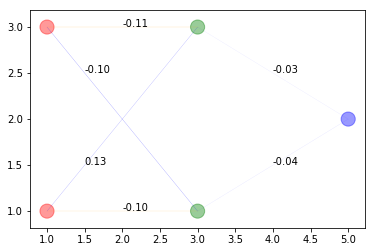

In [37]:
# 训练前的权重

W0=sess.run(ff.W[0])
W1=sess.run(ff.W[1])
print('W_0:\n%s' %sess.run(ff.W[0]))
print('W_1:\n%s' %sess.run(ff.W[1]))

plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'],s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate('%0.2f' %W0[0,0],xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate('%0.2f' %W0[1,0],xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='blue',linewidth=abs(W0[0,1]))
plt.annotate('%0.2f' %W0[0,1],xy=(1.5, 2.5))

plt.plot([1,3],[3,3],color='orange',linewidth=abs(W0[1,1]))
plt.annotate('%0.2f' %W0[1,1],xy=(2, 3))

plt.plot([3,5],[1,2],color='blue',linewidth=abs(W1[0]))
plt.annotate('%0.2f' %W1[0],xy=(4, 1.5))

plt.plot([3,5],[3,2],color='blue',linewidth=abs(W1[1]))
plt.annotate('%0.2f' %W1[1],xy=(4, 2.5))

[[ 0.09383551]
 [ 0.0917989 ]
 [ 0.1       ]
 [ 0.09552652]]


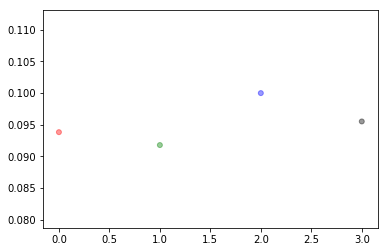

In [38]:
# 训练前的输出
pY=sess.run(ff.output,feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[ 0.1         0.1       ]
 [ 0.2268703   0.        ]
 [ 0.          0.        ]
 [ 0.12375157  0.        ]]


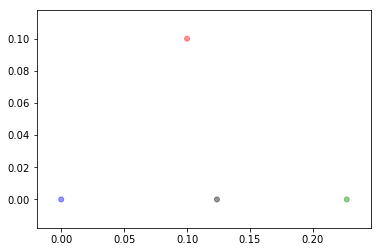

In [39]:
# 训练前隐藏层的输出
pY=sess.run(ff.hid_layers[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

In [40]:
# 训练并记录
k=0.0
for i in range(10000):
    k+=1
    summary, _ = sess.run([merged,ff.train_step],feed_dict={ff.inputs:X.reshape((4,2)),ff.labels:Y.reshape((4,1)),ff.drop_keep_rate:1.0})
    train_writer.add_summary(summary, k)

In [12]:
sess.close()

W_0:
[[-0.5837999   0.5888198 ]
 [-0.59224921 -0.59124792]]
W_1:
[[-0.83480155]
 [ 0.82552969]]


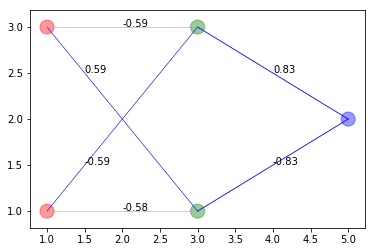

In [27]:
# 训练后的权重

W0=sess.run(ff.W[0])
W1=sess.run(ff.W[1])
print('W_0:\n%s' %sess.run(ff.W[0]))
print('W_1:\n%s' %sess.run(ff.W[1]))

plt.scatter([1,1,5],[1,3,2],color=['red','red','blue'],s=200,alpha=0.4,marker='o')
plt.scatter([3,3],[1,3],color=['green','green'],s=200,alpha=0.4,marker='o')

plt.plot([1,3],[1,1],color='orange',linewidth=abs(W0[0,0]))
plt.annotate('%0.2f' %W0[0,0],xy=(2, 1.0))

plt.plot([1,3],[3,1],color='blue',linewidth=abs(W0[1,0]))
plt.annotate('%0.2f' %W0[1,0],xy=(1.5, 1.5))

plt.plot([1,3],[1,3],color='blue',linewidth=abs(W0[0,1]))
plt.annotate('%0.2f' %W0[0,1],xy=(1.5, 2.5))

plt.plot([1,3],[3,3],color='orange',linewidth=abs(W0[1,1]))
plt.annotate('%0.2f' %W0[1,1],xy=(2, 3))

plt.plot([3,5],[1,2],color='blue',linewidth=abs(W1[0]))
plt.annotate('%0.2f' %W1[0],xy=(4, 1.5))

plt.plot([3,5],[3,2],color='blue',linewidth=abs(W1[1]))
plt.annotate('%0.2f' %W1[1],xy=(4, 2.5))

[[ 0.01287225]
 [ 0.49971908]
 [ 0.98631757]
 [ 0.49971908]]


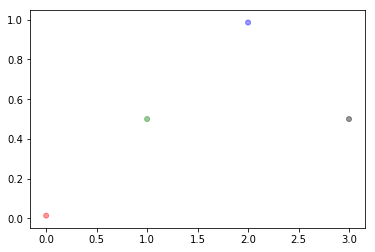

In [28]:
# 训练后的输出
pY=sess.run(ff.output,feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter([0,1,2,3],pY,color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

[[  5.84304988e-01   1.12884538e-03]
 [  0.00000000e+00   0.00000000e+00]
 [  5.05089760e-04   5.89948654e-01]
 [  0.00000000e+00   0.00000000e+00]]


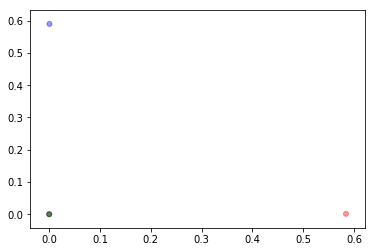

In [29]:
# 训练后隐藏层的输出
pY=sess.run(ff.hid_layers[0],feed_dict={ff.inputs:X.reshape((4,2)),ff.drop_keep_rate:1.0})
print(pY)
plt.scatter(pY[:,0],pY[:,1],color=['red','green','blue','black'],s=25,alpha=0.4,marker='o')

In [ ]:
# 该操作可以用于读取已经训练好的权重W和b
# 每层W想要读取的值
W_0=np.array([[-0.82895017,0.82891428],[ 0.82915729,-0.82918972]],dtype='float32')
W_1=np.array([[ 1.17231631],[ 1.1722393 ]],dtype='float32')
# 每层b想要读取的值
b_0=np.array([0,0],dtype='float32')
b_1=np.array([0],dtype='float32')
# 读取ops
reload1=tf.assign(ff.W[0],W_0)
reload2=tf.assign(ff.W[1],W_1)
reload3=tf.assign(ff.b[0],b_0)
reload4=tf.assign(ff.b[1],b_1)
# 执行ops
sess.run([reload1,reload2,reload3,reload4])

In [ ]:
np.maximum(0, X.reshape((4,2)).dot(W_0) + b_0).dot(W_1) + b_1

In [ ]:
sess.run(ff.W[1])

In [ ]:
sess.run(ff.output, feed_dict={ff.inputs:X.reshape((4,2)), ff.drop_keep_rate:1.0})

In [ ]:
######################################################################################################

In [6]:
class FNN(object):
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate : float
    drop_out : float
    Layers : list
        The number of layers
    N_hidden : list
        The numbers of nodes in layers
    D_input : int
        Input dimension
    D_label : int
        Label dimension
    Task_type : string
        'regression' or 'classification'
    L2_lambda : float
    Auther : YJango; 2016/11/25
    """
    def __init__(self, learning_rate, Layers, N_hidden, D_input, D_label, Task_type='regression', L2_lambda=0.0):
        
        #var
        self.learning_rate = learning_rate
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        # 类型控制loss函数的选择
        self.Task_type = Task_type
        # l2 regularization的惩罚强弱，过高会使得输出都拉向0
        self.L2_lambda = L2_lambda
        # 用于存放所累积的每层l2 regularization
        self.l2_penalty = tf.constant(0.0)
        
        # 用于生成tensorflow缩放图的,括号里起名字
        with tf.name_scope('Input'):
            self.inputs = tf.placeholder(tf.float32, [None, D_input], name="inputs")
        with tf.name_scope('Label'):
            self.labels = tf.placeholder(tf.float32, [None, D_label], name="labels")
        with tf.name_scope('keep_rate'):
            self.drop_keep_rate = tf.placeholder(tf.float32, name="dropout_keep")
        

        # 初始化的时候直接生成，build方法是后面会建立的
        self.build('F')
        
    def weight_init(self,shape):
        # shape : list [in_dim, out_dim]
        # 在这里更改初始化方法
        # 方式1：下面的权重初始化若用ReLU激活函数，可以使用带有6个隐藏层的神经网络
        #       若过深，则使用dropout会难以拟合。
        #initial = tf.truncated_normal(shape, stddev=0.1)/ np.sqrt(shape[1])
        # 方式2：下面的权重初始化若用ReLU激活函数，可以扩展到15个隐藏层以上（通常不会用那么多）
        initial = tf.random_uniform(shape,minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
        return tf.Variable(initial)

    def bias_init(self,shape):
        # can change initialization here
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name+'_summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean/' + name, mean)
        with tf.name_scope(name+'_stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # 记录每次训练后变量的数值变化
        tf.summary.scalar('_stddev/' + name, stddev)
        tf.summary.scalar('_max/' + name, tf.reduce_max(var))
        tf.summary.scalar('_min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)

    def layer(self,in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name+'_weights'):
                # 用所建立的weight_init函数进行初始化。
                weights = self.weight_init([in_dim, out_dim])
                # 存放着每一个权重W
                self.W.append(weights)
                # 对权重进行统计
                self.variable_summaries(weights, layer_name + '/weights')
            with tf.name_scope(layer_name+'_biases'):
                biases = self.bias_init([out_dim])
                # 存放着每一个偏移b
                self.b.append(biases)
                self.variable_summaries(biases, layer_name + '/biases')
            with tf.name_scope(layer_name+'_Wx_plus_b'):
                # 计算Wx+b
                pre_activate = tf.matmul(in_tensor, weights) + biases
                # 记录直方图
                tf.summary.histogram(layer_name + '/pre_activations', pre_activate)
            # 计算a(Wx+b)
            activations = act(pre_activate, name='activation')
            tf.summary.histogram(layer_name + '/activations', activations)
        # 最终返回该层的输出，以及权重W的L2
        return activations, tf.nn.l2_loss(weights)

    def drop_layer(self,in_tensor):
            #tf.scalar_summary('dropout_keep', self.drop_keep_rate)
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped

    def build(self, prefix):
        # 建立网络 
        # incoming也代表当前tensor的流动位置
        incoming = self.inputs
        # 如果没有隐藏层
        if self.Layers!=0:
            layer_nodes = [self.D_input] + self.N_hidden
        else:
            layer_nodes = [self.D_input]
        
        # hid_layers用于存储所有隐藏层的输出
        self.hid_layers=[]
        # W用于存储所有层的权重
        self.W=[]
        # b用于存储所有层的偏移
        self.b=[]
        # total_l2用于存储所有层的L2
        self.total_l2=[]
        
        # 开始叠加隐藏层。这跟千层饼没什么区别。
        for l in range(self.Layers):
            # 使用刚才编写的函数来建立层，并更新incoming的位置
            incoming,l2_loss= self.layer(incoming,layer_nodes[l],layer_nodes[l+1],prefix+'_hid_'+str(l+1),act=tf.nn.relu)
            # 累计l2
            self.total_l2.append(l2_loss)
            # 输出一些信息，让我们知道网络在建造中做了什么
            print('Add dense layer: relu')
            print('    %sD --> %sD' %(layer_nodes[l],layer_nodes[l+1]))
            # 存储所有隐藏层的输出
            self.hid_layers.append(incoming)
            # 加入dropout层
            incoming = self.drop_layer(incoming)
            
        # 输出层的建立。输出层需要特别对待的原因是输出层的activation function要根据任务来变。
        # 回归任务的话，下面用的是tf.identity，也就是没有activation function
        if self.Task_type=='regression':
            out_act=tf.identity
        else:
            # 分类任务使用softmax来拟合概率
            out_act=tf.nn.softmax
        self.output,l2_loss= self.layer(incoming,layer_nodes[-1],self.D_label, layer_name='output',act=out_act)
        self.total_l2.append(l2_loss)
        print('Add output layer: linear')
        print('    %sD --> %sD' %(layer_nodes[-1],self.D_label))
        
        # l2 loss的缩放图
        with tf.name_scope('total_l2'):
            for l2 in self.total_l2:
                self.l2_penalty+=l2
            tf.summary.scalar('l2_penalty', self.l2_penalty)
            
        # 不同任务的loss
        # 若为回归，则loss是用于判断所有预测值和实际值差别的函数。
        if self.Task_type=='regression':
            with tf.name_scope('SSE'):
                self.loss=tf.reduce_mean((self.output-self.labels)**2)
                self.loss2=tf.nn.l2_loss(self.output-self.labels)
                
                tf.summary.scalar('loss', self.loss)
        else:
            # 若为分类，cross entropy的loss function
            entropy = tf.nn.softmax_cross_entropy_with_logits(self.output, self.labels)
            with tf.name_scope('cross entropy'):
                self.loss = tf.reduce_mean(entropy)
                tf.summary.scalar('loss', self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.summary.scalar('accuracy', self.accuracy)
                
        # 整合所有loss，形成最终loss
        with tf.name_scope('total_loss'):
            self.total_loss=self.loss + self.l2_penalty*self.L2_lambda
            tf.summary.scalar('total_loss', self.total_loss)
            
        # 训练操作
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)

        # 洗牌功能
    def shufflelists(self,lists):
        ri=np.random.permutation(len(lists[1]))
        out=[]
        for l in lists:
            out.append(l[ri])
        return out

In [7]:
def Standardize(seq):
    #subtract mean
    centerized=seq-np.mean(seq, axis = 0)
    #divide standard deviation
    normalized=centerized/np.std(centerized, axis = 0)
    return normalized
def Makewindows(indata,window_size=41):
    outdata=[]
    mid=int(window_size/2)
    indata=np.vstack((np.zeros((mid,indata.shape[1])), indata, np.zeros((mid,indata.shape[1]))))
    for i in range(indata.shape[0]-window_size+1):
        outdata.append(np.hstack(indata[i:i+window_size]))
    return np.array(outdata)

In [8]:
mfc=np.load('./YJango/tensorflow/X.npy')
art=np.load('./YJango/tensorflow/Y.npy')
x=[]
y=[]
for i in range(len(mfc)):
    x.append(Makewindows(Standardize(mfc[i])))
    y.append(Standardize(art[i]))

vali_size=20
totalsamples=len(np.vstack(x))
X_train=np.vstack(x)[int(totalsamples/vali_size):].astype("float32")
Y_train=np.vstack(y)[int(totalsamples/vali_size):].astype("float32")

X_test=np.vstack(x)[:int(totalsamples/vali_size)].astype("float32")
Y_test=np.vstack(y)[:int(totalsamples/vali_size)].astype("float32")

In [10]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

((37500, 1599), (37500, 24), (1973, 1599), (1973, 24))


In [11]:
# 生成网络实例
ff=FNN(learning_rate=7e-5, Layers=5, N_hidden=[2048,1024,512,256,128], D_input=1599, D_label=24, L2_lambda=1e-4)

Add dense layer: relu
    1599D --> 2048D
Add dense layer: relu
    2048D --> 1024D
Add dense layer: relu
    1024D --> 512D
Add dense layer: relu
    512D --> 256D
Add dense layer: relu
    256D --> 128D
Add output layer: linear
    128D --> 24D


In [17]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.global_variables_initializer().run()
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log3' + '/train',sess.graph)
test_writer = tf.summary.FileWriter('log3' + '/test')

In [22]:
# 训练并记录
k=0
Batch=32
for i in range(50):
    idx=0
    X0,Y0=ff.shufflelists([X_train,Y_train])
    while idx<X_train.shape[0]:
#         summary, _ = sess.run([merged, ff.train_step], \
        sess.run([ff.train_step], \
            feed_dict={ff.inputs:X0[idx:idx+Batch],ff.labels:Y0[idx:idx+Batch],ff.drop_keep_rate:1.0})#当keep rate设为1.0时，表示不运用dropout
        idx+=Batch
        k+=1
#         train_writer.add_summary(summary, k)
    #test
#     summary,pY,pL=sess.run([merged,ff.output,ff.loss],feed_dict={ff.inputs:X_test,ff.labels:Y_test,ff.drop_keep_rate:1.0})
    pY,pL=sess.run([ff.output,ff.loss],feed_dict={ff.inputs:X_test,ff.labels:Y_test,ff.drop_keep_rate:1.0})
    plots(Y_test,pY,i)
#     test_writer.add_summary(summary, k)
    print('epoch%s | train_loss:%s |test_loss:%s' % \
        (i,sess.run(ff.loss,feed_dict={ff.inputs:X0,ff.labels:Y0,ff.drop_keep_rate:1.0}),
         sess.run(ff.loss,feed_dict={ff.inputs:X_test,ff.labels:Y_test,ff.drop_keep_rate:1.0}) ) )

epoch0 | train_loss:0.153061 |test_loss:0.435396
epoch1 | train_loss:0.113214 |test_loss:0.413357
epoch2 | train_loss:0.0885114 |test_loss:0.414095
epoch3 | train_loss:0.0753423 |test_loss:0.417356
epoch4 | train_loss:0.0635002 |test_loss:0.410296


KeyboardInterrupt: 

In [20]:
def plots(T,P,i, n=21,length=400):
    m=0
    plt.figure(figsize=(20,16))
    plt.subplot(411)
    plt.plot(T[m:m+length,7],'--')
    plt.plot(P[m:m+length,7])

    plt.subplot(412)
    plt.plot(T[m:m+length,8],'--')
    plt.plot(P[m:m+length,8])
    
    plt.subplot(413)
    plt.plot(T[m:m+length,15],'--')
    plt.plot(P[m:m+length,15])
    
    plt.subplot(414)
    plt.plot(T[m:m+length,16],'--')
    plt.plot(P[m:m+length,16])
    plt.legend(['True','Predicted'])
    plt.savefig('epoch'+str(i)+'.png')
    plt.close()

In [ ]:
####################################################################################################################

In [3]:
import time

In [4]:
def Standardize(seq):
    #subtract mean
    centerized=seq-np.mean(seq, axis = 0)
    #divide standard deviation
    normalized=centerized/np.std(centerized, axis = 0)
    return normalized
mfc=np.load('./tensorflow/X.npy')
art=np.load('./tensorflow/Y.npy')
totalsamples=len(mfc)
vali_size=0.2
def data_prer(X, Y):
    D_input=X[0].shape[1]
    D_output=24
    data=[]
    for x,y in zip(X,Y):
        data.append([Standardize(x).reshape((1,-1,D_input)).astype("float32"),
                     Standardize(y).astype("float32")])
    return data
data=data_prer(mfc, art)
train=data[int(totalsamples*vali_size):]
test=data[:int(totalsamples*vali_size)]
print('num of train sequences:%s' %len(train))
print('num of test sequences:%s' %len(test))
print('shape of inputs:' ,test[0][0].shape)
print('shape of labels:' ,test[0][1].shape)

num of train sequences:83
num of test sequences:20
('shape of inputs:', (1, 886, 39))
('shape of labels:', (886, 24))


In [5]:
def weight_init(shape):
    initial = tf.random_uniform(shape,minval=-np.sqrt(5)*np.sqrt(1.0/shape[0]), maxval=np.sqrt(5)*np.sqrt(1.0/shape[0]))
    return tf.Variable(initial,trainable=True)

def zero_init(shape):
    initial = tf.Variable(tf.zeros(shape))
    return tf.Variable(initial,trainable=True)

def orthogonal_initializer(shape,scale = 1.0):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    scale = 1.0
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape) #this needs to be corrected to float32
    return tf.Variable(scale * q[:shape[0], :shape[1]],trainable=True, dtype=tf.float32)

def bias_init(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)
def shufflelists(data):
    ri=np.random.permutation(len(data))
    data=[data[i] for i in ri]
    return data

In [6]:
class LSTMcell(object):
    def __init__(self, incoming, D_input, D_cell, initializer, f_bias=1.0):
        
        # var
        # the shape of incoming is [n_samples, n_steps, D_cell]
        self.incoming = incoming
        self.D_input = D_input
        self.D_cell = D_cell
        # parameters
          # igate = W_xi.* x + W_hi.* h + b_i
        self.W_xi = initializer([self.D_input, self.D_cell])
        self.W_hi = initializer([self.D_cell, self.D_cell])
        self.b_i  = tf.Variable(tf.zeros([self.D_cell]))  
          # fgate = W_xf.* x + W_hf.* h + b_f
        self.W_xf = initializer([self.D_input, self.D_cell])
        self.W_hf = initializer([self.D_cell, self.D_cell])
        self.b_f  = tf.Variable(tf.constant(f_bias, shape=[self.D_cell])) 
          # ogate = W_xo.* x + W_ho.* h + b_o
        self.W_xo = initializer([self.D_input, self.D_cell])
        self.W_ho = initializer([self.D_cell, self.D_cell])
        self.b_o  = tf.Variable(tf.zeros([self.D_cell])) 
          # cell = W_xc.* x + W_hc.* h + b_c
        self.W_xc = initializer([self.D_input, self.D_cell])
        self.W_hc = initializer([self.D_cell, self.D_cell])
        self.b_c  = tf.Variable(tf.zeros([self.D_cell]))  
        
        # init cell and hidden state whose shapes are [n_samples, D_cell]
        init_for_both = tf.matmul(self.incoming[:,0,:], tf.zeros([self.D_input, self.D_cell]))
        self.hid_init = init_for_both
        self.cell_init = init_for_both
        # because tf.scan only takes two arguments, the hidden state and cell are needed to merge
        self.previous_h_c_tuple = tf.stack([self.hid_init, self.cell_init])
        # transpose the tensor so that the first dim is time_step
        self.incoming = tf.transpose(self.incoming, perm=[1,0,2])
        
    def one_step(self, previous_h_c_tuple, current_x):
        
        # to split hidden state and cell
        prev_h, prev_c = tf.unstack(previous_h_c_tuple)
        
        # computing
        # input gate
        i = tf.sigmoid(
            tf.matmul(current_x, self.W_xi) + 
            tf.matmul(prev_h, self.W_hi) + 
            self.b_i)
        
        # forget Gate
        f = tf.sigmoid(
            tf.matmul(current_x, self.W_xf) + 
            tf.matmul(prev_h, self.W_hf) + 
            self.b_f)
        # output Gate
        o = tf.sigmoid(
            tf.matmul(current_x, self.W_xo) + 
            tf.matmul(prev_h, self.W_ho) + 
            self.b_o)
        # new cell info
        c = tf.tanh(
            tf.matmul(current_x, self.W_xc) + 
            tf.matmul(prev_h, self.W_hc) + 
            self.b_c)
        # current cell 
        current_c = f*prev_c + i*c
        # current hidden state
        current_h = o*tf.tanh(current_c)
        
#         print tf.stack([current_h, current_c]).shape, (tf.stack([current_h, current_c]))
#         print current_x.shape, i.shape, self.W_xi.shape, current_h.shape, current_c.shape
        return tf.stack([current_h, current_c])
    
    def all_steps(self):
        # inputs shape : [n_sample, n_steps, D_input]
        # outputs shape : [n_steps, n_sample, D_output]
        
        #incomint经过了转置，应该是[n_step, 1, D_input]
        #那么scan的结果就是，[step, 2, 1, D_cell]
        #那么hstates 的结果就是 [step, 1, D_cell]
        scan_result = tf.scan(fn = self.one_step,
                          elems = self.incoming,
                          initializer = self.previous_h_c_tuple,
                          name = 'scan_result')
        hstates = tf.scan(fn = self.one_step,
                          elems = self.incoming,
                          initializer = self.previous_h_c_tuple,
                          name = 'hstates')[:,0,:,:]
        return hstates, scan_result

In [7]:
D_input = 39
D_label = 24
learning_rate = 7e-5
num_units = 1024

inputs = tf.placeholder(tf.float32, [None, None, D_input], name="inputs")
labels = tf.placeholder(tf.float32, [None, D_label], name="labels")

rnn_cell = LSTMcell(inputs, D_input, num_units, orthogonal_initializer) #将rnn_cell看做一个整体，就是一个节点。

#hstates 的shape 为[len(self.incoming) fn().shape] ,也就是[none, 2, none, 1024]，
#那么 rnn0 取的是 hid 状态， 那么shape就是[none, none, 1024]
#第一个none是
rnn0,scan_result = rnn_cell.all_steps()

# reshape for output layer
rnn = tf.reshape(rnn0, [-1, num_units])   #shape, [n_step, D_cell]
# output layer
W = weight_init([num_units, D_label])     #shape, [D_cell, D_label]
b = bias_init([D_label])
output = tf.matmul(rnn, W) + b

loss=tf.reduce_mean((output-labels)**2)    #没有求根号，所以可以这样，求了根号，就不一样了。

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
#训练是只用了一个样本
#那么n_sample就是 1
#如果用多个样本，但是每个样本的step不一样，怎么训练？
#先只考虑为n_smaple 为 1 的情况

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [39]:
# 训练并记录
def train_epoch(EPOCH):
    for k in range(EPOCH):
        train0=shufflelists(train)
        for i in range(len(train)):
#             a = sess.run([tf.shape(inputs), tf.shape(scan_result), tf.shape(rnn0), 
#                           tf.shape(rnn), tf.shape(W), tf.shape(b), tf.shape(output)], feed_dict={inputs:train0[i][0]})
#             print a
            sess.run(train_step,feed_dict={inputs:train0[i][0],labels:train0[i][1]})
        tl=0
        dl=0
        for i in range(len(test)):
            dl+=sess.run(loss,feed_dict={inputs:test[i][0],labels:test[i][1]})
        for i in range(len(train)):
            tl+=sess.run(loss,feed_dict={inputs:train[i][0],labels:train[i][1]})
        print(k,'train:',round(tl/len(train),3),'test:',round(dl/len(test),3))

t0 = time.time()
train_epoch(100)
t1 = time.time()
print(" %f seconds" % round((t1 - t0),2))

(0, 'train:', 0.21, 'test:', 0.447)
(1, 'train:', 0.2, 'test:', 0.44)
(2, 'train:', 0.183, 'test:', 0.432)
(3, 'train:', 0.172, 'test:', 0.437)
(4, 'train:', 0.164, 'test:', 0.434)
(5, 'train:', 0.156, 'test:', 0.435)
(6, 'train:', 0.154, 'test:', 0.447)
(7, 'train:', 0.144, 'test:', 0.427)
(8, 'train:', 0.138, 'test:', 0.431)
(9, 'train:', 0.133, 'test:', 0.423)
(10, 'train:', 0.126, 'test:', 0.426)
(11, 'train:', 0.12, 'test:', 0.432)
(12, 'train:', 0.115, 'test:', 0.43)
(13, 'train:', 0.11, 'test:', 0.429)
(14, 'train:', 0.108, 'test:', 0.43)
(15, 'train:', 0.106, 'test:', 0.429)
(16, 'train:', 0.106, 'test:', 0.429)
(17, 'train:', 0.1, 'test:', 0.433)
(18, 'train:', 0.099, 'test:', 0.422)
(19, 'train:', 0.096, 'test:', 0.428)
(20, 'train:', 0.095, 'test:', 0.431)
(21, 'train:', 0.094, 'test:', 0.436)
(22, 'train:', 0.088, 'test:', 0.422)
(23, 'train:', 0.085, 'test:', 0.429)
(24, 'train:', 0.084, 'test:', 0.422)
(25, 'train:', 0.082, 'test:', 0.422)
(26, 'train:', 0.078, 'test:', 0

In [19]:
a = [i[0].shape for i in train]

In [21]:
b = [i[0].shape for i in test]

In [22]:
b

[(1, 886, 39),
 (1, 192, 39),
 (1, 150, 39),
 (1, 257, 39),
 (1, 165, 39),
 (1, 223, 39),
 (1, 345, 39),
 (1, 2347, 39),
 (1, 1804, 39),
 (1, 296, 39),
 (1, 235, 39),
 (1, 348, 39),
 (1, 385, 39),
 (1, 259, 39),
 (1, 148, 39),
 (1, 277, 39),
 (1, 252, 39),
 (1, 132, 39),
 (1, 304, 39),
 (1, 315, 39)]

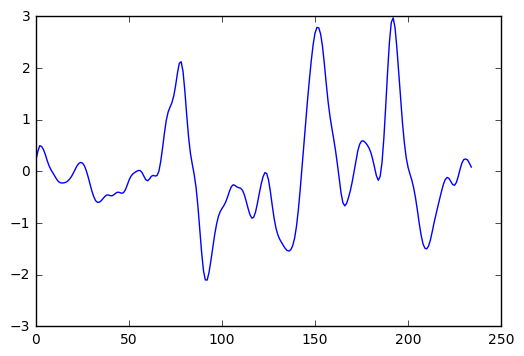

In [25]:
plt.plot(test[10][1][:, 8])

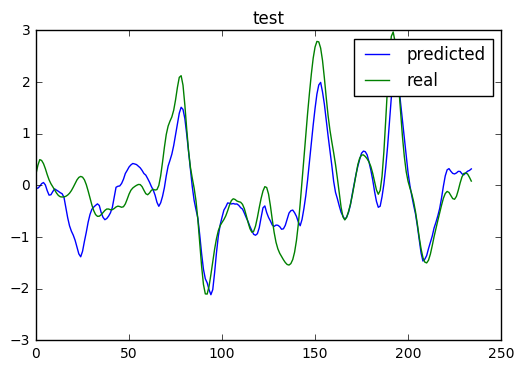

In [34]:
pY=sess.run(output,feed_dict={inputs:test[10][0]})
plt.plot(pY[:,8])
plt.plot(test[10][1][:,8])
plt.title('test')
plt.legend(['predicted','real'])

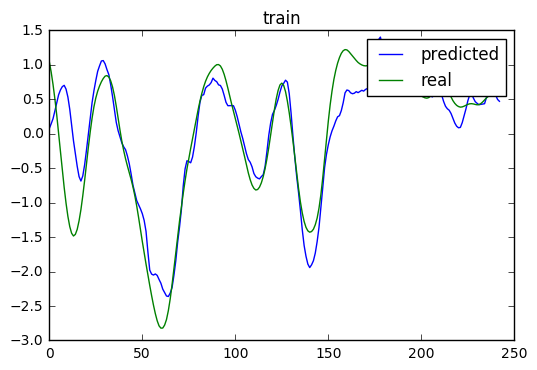

In [35]:
pY=sess.run(output,feed_dict={inputs:train[1][0]})
plt.plot(pY[:,6])
plt.plot(train[1][1][:,6])
plt.title('train')
plt.legend(['predicted','real'])

In [15]:
sum(a)

30153

In [ ]:
sess.close()

In [ ]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

In [ ]:
np.arange(max(0, 10 - 2), 10+1)[::-1]

In [ ]:
# 目标函数:y=x^2
def func(x):
    return np.square(x)


# 目标函数一阶导数:dy/dx=2*x
def dfunc(x):
    return 2 * x

def GD_momentum(x_start, df, epochs, lr, momentum):
    """
    带有冲量的梯度下降法。
    :param x_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param epochs: 迭代周期
    :param lr: 学习率
    :param momentum: 冲量
    :return: x在每次迭代后的位置（包括起始点），长度为epochs+1
    """
    xs = np.zeros(epochs+1)
    x = x_start
    xs[0] = x
    v = 0
    for i in range(epochs):
        dx = df(x)
        # v表示x要改变的幅度
        v = - dx * lr + momentum * v
        x += v
        xs[i+1] = x
    return xs

In [ ]:
def demo2_GD_momentum():
    line_x = np.linspace(-5, 5, 100)
    line_y = func(line_x)
    plt.figure('Gradient Desent: Learning Rate, Momentum')

    x_start = -5
    epochs = 6

    lr = [0.01, 0.1, 0.6, 0.9]
    momentum = [0.0, 0.1, 0.5, 0.9]

    color = ['k', 'r', 'g', 'y']

    row = len(lr)
    col = len(momentum)
    size = np.ones(epochs+1) * 10
    size[-1] = 70
    for i in range(row):
        for j in range(col):
            x = GD_momentum(x_start, dfunc, epochs, lr=lr[i], momentum=momentum[j])
            plt.subplot(row, col, i * col + j + 1)
            plt.plot(line_x, line_y, c='b')
            plt.plot(x, func(x), c=color[i])#, label='lr={}, mo={}'.format(lr[i], momentum[j]))
            plt.scatter(x, func(x), c=color[i], s=size)
            plt.legend(loc=0)
    plt.show()

In [ ]:

demo2_GD_momentum()

In [ ]:
a = [np.random.randn(i, 1) for i in [2,3]]

In [ ]:
a

In [ ]:
a = np.array(a)

In [ ]:
a.shape

In [ ]:
sum(a)

In [ ]:
64 *128

In [ ]:
a = pd.Series(np.random.randint(0,70, 2000) / 10.0)

In [ ]:
a.to_csv('answer.csv', index = False)

In [ ]:
df = pd.read_csv('./cikm/data_new/CIKM2017_train/data_sample.txt', header = None, index_col = 0)

In [ ]:
df.columns

In [ ]:
df.index

In [ ]:
df.shape

In [ ]:
df

In [ ]:
a = df.iloc[1, 1]

In [ ]:
b = a.split(' ')

In [ ]:
b?

In [ ]:
RATE_MATRIX = np.array(
    [[5, 5, 3, 0, 5, 5],
     [5, 0, 4, 0, 4, 4],
     [0, 3, 0, 5, 4, 5],
     [5, 4, 3, 3, 5, 5]]
)

nmf = NMF(n_components=2)  # 设有2个隐主题
user_distribution = nmf.fit_transform(RATE_MATRIX)
item_distribution = nmf.components_

print '用户的主题分布：'
print user_distribution
print '物品的主题分布：'
print item_distribution

In [ ]:
nmf.

In [ ]:
a = np.array([[1,2],[2,3.999]])
a

In [ ]:
x = np.array([[-3.999],[4]])
x

In [ ]:
a.dot(x)

In [ ]:
def f(x, a):
    return x*x - a;

def df(x, a):
    return 2*x

def newton_sqrt(a):
    a = float(a)
    EPS = 0.001
    xn = a;
    while f(xn, a) > EPS:
        f_xn = f(xn, a) 
        df_xn = df(xn, a)
        xn = -1.0 * f(xn, a) / df(xn, a) + xn
    return xn

In [ ]:
newton_sqrt(3)